# Import libraries

In [ ]:
import os
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import json
from time import time

# Import utils.py
!gdown 'https://drive.google.com/uc?id=13I5w4WajPg6MObtLPQjxznm8w5hKlEY0' -O ./utils.py
from utils import *

Downloading...
From: https://drive.google.com/uc?id=13I5w4WajPg6MObtLPQjxznm8w5hKlEY0
To: /content/utils.py
100% 10.1k/10.1k [00:00<00:00, 18.2MB/s]


# Omics retrieval

## Download GDC client

In [ ]:
# Download gdc-client
if not os.path.exists("gdc-client"):
    !wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
    !unzip -n gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
    !rm gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip

--2021-07-06 07:41:45--  https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
Resolving gdc.cancer.gov (gdc.cancer.gov)... 192.170.230.224, 2605:9a00:10:4008::101
Connecting to gdc.cancer.gov (gdc.cancer.gov)|192.170.230.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19603683 (19M) [application/zip]
Saving to: ‘gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip’

gdc-client_v1.6.0_U 100%[===================>]  18.70M  21.8MB/s    in 0.9s    

2021-07-06 07:41:46 (21.8 MB/s) - ‘gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip’ saved [19603683/19603683]

Archive:  gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
  inflating: gdc-client              


## Download manifest and json files

In [ ]:
# Create new folder in which to store manifest and json files
!mkdir -p manifest_and_json



# Download manifest and json files
if not os.path.exists("./manifest_and_json/mRNA_manifest.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mIGA6d2kleAs2QfreO00lPSi6v_dYiwg' -O ./manifest_and_json/mRNA_manifest.txt
if not os.path.exists("./manifest_and_json/mRNA.json"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y1dJHV8TCAIWKLHRGP8DTj96v3h36lwf' -O ./manifest_and_json/mRNA.json

if not os.path.exists("./manifest_and_json/miRNA_manifest.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14Z6K7dA0yQ4bay_Zh_XgexQpbeShAaqG' -O ./manifest_and_json/miRNA_manifest.txt
if not os.path.exists("./manifest_and_json/miRNA.json"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R8Zqxs52mgviUFWF1Ok2jKO9WAb4tR_x' -O ./manifest_and_json/miRNA.json

if not os.path.exists("./manifest_and_json/meth_manifest.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1O0ebMaUZ9oB-W0yv5JJjagDGlWaZlBMQ' -O ./manifest_and_json/meth_manifest.txt
if not os.path.exists("./manifest_and_json/meth.json"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GWMmy-ylTcp926ZZhUxi4vA9OUNx9Nee' -O ./manifest_and_json/meth.json

# Download the list of the relative indices of the probes of a illumina meth 450k
# which are in common between the Illumina human methylation 27 and 450 platforms
# NB: the file meth_450_indices.txt has been obtained in the colab notebook 'Find common meth probes illumina 27k/450k'
if not os.path.exists("meth_450_indices.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IECKLh5TALSoaoaUQsfP7Cw0Gud-g5_6' -O meth_450_indices.txt
    

--2021-07-06 07:41:47--  https://docs.google.com/uc?export=download&id=1mIGA6d2kleAs2QfreO00lPSi6v_dYiwg
Resolving docs.google.com (docs.google.com)... 142.250.128.113, 142.250.128.138, 142.250.128.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.128.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hpcnpn9tbkb4log8am9nsh5qa0fanfh3/1625557275000/13228068855151958278/*/1mIGA6d2kleAs2QfreO00lPSi6v_dYiwg?e=download [following]
--2021-07-06 07:41:48--  https://doc-00-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hpcnpn9tbkb4log8am9nsh5qa0fanfh3/1625557275000/13228068855151958278/*/1mIGA6d2kleAs2QfreO00lPSi6v_dYiwg?e=download
Resolving doc-00-c8-docs.googleusercontent.com (doc-00-c8-docs.googleusercontent.com)... 173.194.197.132, 2607:f8b0:4001:c1b::84
Connecting to doc-00-c8-docs.googleusercontent.com (doc-00

## Cross json files

 to keep only the samples for which we have all the omics

In [ ]:
# Read the mRNA json file
with open('manifest_and_json/mRNA.json') as f:
  data = json.load(f)
df = pd.json_normalize(data, 'cases', 'file_name')

# Delete entries related to TCGA-SARC kidney tumor
df = df[(df['project.project_id'].isin(['TCGA-KICH','TCGA-KIRP','TCGA-KIRC']))]

print("Are there patients with 2+ files?", any(df['case_id'].duplicated()))

# Discard patients with 2+ associated files
mRNA_df = df.drop_duplicates(subset='case_id', keep=False)

mRNA_df

Are there patients with 2+ files? True


,case_id,project.project_id,file_name
0,82f069c4-7928-4b7b-8a42-114db7de0501,TCGA-KIRC,6e2123ba-f414-492b-b3ea-76cdb8b49da7.FPKM-UQ.t...
1,151f07f5-1529-4fcd-912c-e55b2ff8abef,TCGA-KICH,401beb60-1256-4cac-ab66-f5a25ca8e3a6.FPKM-UQ.t...
2,739deed4-d1dc-458f-bd0f-1e24d2bfd305,TCGA-KICH,7f366a6f-9823-4b4d-a785-a5487dcb8b5e.FPKM-UQ.t...
3,2ed3296a-5b10-40d8-8af4-90dc031657cd,TCGA-KIRC,44925f20-dad5-40de-99b6-e8164abe94ed.FPKM-UQ.t...
4,6b79d20c-d5bc-4580-837e-b36dfd0c199c,TCGA-KIRC,4d813387-15db-4d2f-bf85-1c79874aa179.FPKM-UQ.t...
...,...,...,...
887,87971996-94d7-4e88-8ed5-e059db838af7,TCGA-KIRP,f2b956bb-2268-4968-847d-898f5dc4be96.FPKM-UQ.t...
888,048ebea2-47ef-4359-9213-a1b7e4fdecf0,TCGA-KIRP,300d3f59-4290-40a5-9df6-59284d790aac.FPKM-UQ.t...
889,d61e22d8-c3ce-4237-83d7-da188b9fd456,TCGA-KIRP,881bb503-95c6-4a88-9267-da8174ce4350.FPKM-UQ.t...
891,b02a2698-d4d3-4977-a251-989694d60f73,TCGA-KIRP,9cd571a0-0fd0-46c7-84b9-9ec95beb4ac5.FPKM-UQ.t...


In [ ]:
# Read the miRNA json file
with open('manifest_and_json/miRNA.json') as f:
  data = json.load(f)
df = pd.json_normalize(data, 'cases', 'file_name')

# Delete entries related to TCGA-SARC kidney tumor
df = df[(df['project.project_id'].isin(['TCGA-KICH','TCGA-KIRP','TCGA-KIRC']))]

print("Are there patients with 2+ files?", any(df['case_id'].duplicated()))

# Discard patients with 2+ associated files
miRNA_df = df.drop_duplicates(subset='case_id', keep=False)

miRNA_df

Are there patients with 2+ files? True


,case_id,project.project_id,file_name
0,6b0c1e54-b643-4490-927e-d5c91957d5d2,TCGA-KIRC,ddf3debd-c7ee-4f25-bd43-dcda12320f89.mirbase21...
1,4c474c70-1d72-49e8-a8cc-a4145c5ab607,TCGA-KIRC,205b1429-92c6-474e-ad2c-84e8fd749a62.mirbase21...
2,03905b58-4b13-410c-8e92-115ab2a42e80,TCGA-KIRC,8677fd49-4e65-4553-83ec-30d8c9dee4a1.mirbase21...
3,7e620e32-54c5-4f5b-9e18-211516a3eb41,TCGA-KIRC,c0fd4094-9549-49a4-a0b0-0afbe0bb4751.mirbase21...
5,4519a839-11ea-4628-b5a7-071833ad16de,TCGA-KIRC,d76831de-59a7-4676-975b-2301724ca535.mirbase21...
...,...,...,...
898,9fc40b03-0b56-4b1f-93ed-dbc455ae3fd9,TCGA-KIRP,8bcd1090-54b1-485a-a5a3-7eced163289f.mirbase21...
899,75a53bff-bf0f-4ad8-9b8e-14a27914d4f2,TCGA-KIRP,8451278a-6c35-4afd-aea9-6aae4b09a362.mirbase21...
900,781c4776-7f82-4bc5-a490-291ebcebbca4,TCGA-KIRP,055267a1-2aff-4af5-9c6d-5a7b733fcb16.mirbase21...
901,a0f4ee95-b457-43cf-8b6c-0b6882dd99ce,TCGA-KIRP,cec40783-2f8e-4abb-95ab-3f76ca294bcb.mirbase21...


In [ ]:
# Read the meth json file
with open('manifest_and_json/meth.json') as f:
  data = json.load(f)
df = pd.json_normalize(data, 'cases', 'file_name')

# Delete entries related to TCGA-SARC kidney tumor
df = df[(df['project.project_id'].isin(['TCGA-KICH','TCGA-KIRP','TCGA-KIRC']))]

print("Are there patients with 2+ files?", any(df['case_id'].duplicated()))

# Discard patients with 2+ associated files
meth_df = df.drop_duplicates(subset='case_id', keep=False)

meth_df

Are there patients with 2+ files? True


,case_id,project.project_id,file_name
0,8a575e00-5dc5-416d-a8f5-2cdfb8e62c31,TCGA-KIRC,jhu-usc.edu_KIRC.HumanMethylation450.5.lvl-3.T...
1,4cfe9a35-80f2-422b-82e8-8f4b12ded992,TCGA-KIRC,jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.T...
2,315b6dea-02c6-44dc-9788-a72f78fae815,TCGA-KIRC,jhu-usc.edu_KIRC.HumanMethylation450.3.lvl-3.T...
3,88c91a7b-5c41-4361-85d0-da759ab94204,TCGA-KIRC,jhu-usc.edu_KIRC.HumanMethylation450.6.lvl-3.T...
4,ab5266f6-8015-4347-b0bd-131ab1fbad51,TCGA-KIRC,jhu-usc.edu_KIRC.HumanMethylation450.6.lvl-3.T...
...,...,...,...
662,ad7ba244-67fa-4155-8f13-424bdcbb12e5,TCGA-KIRP,jhu-usc.edu_KIRP.HumanMethylation450.15.lvl-3....
663,91a605b2-929a-44ce-8522-2ff793ddf82f,TCGA-KIRP,jhu-usc.edu_KIRP.HumanMethylation450.1.lvl-3.T...
664,8af42b33-6ab7-4ea0-860d-f3af9177ee2d,TCGA-KIRP,jhu-usc.edu_KIRP.HumanMethylation450.9.lvl-3.T...
665,072507cf-1249-4b28-86d4-3ab97822a74c,TCGA-KIRP,jhu-usc.edu_KIRP.HumanMethylation450.6.lvl-3.T...


In [ ]:
# Outer join on mRNA_df.case_id == miRNA_df.case_id == meth_df.case_id == cnv_df.case_id
col_mask = [col for col in mRNA_df.columns if col != "project.project_id"] # we want to drop the project_id in miRNA_df, meth_df, cnv_df, so to avoid duplicate columns when merging

merged_df = mRNA_df.merge(miRNA_df[col_mask], how='outer', on="case_id", suffixes=('_mRNA', '_miRNA')) \
                   .merge(meth_df[col_mask], how='outer', on="case_id").rename(columns={'file_name':'file_name_meth'}) \

# Drop rows with NaN values (i.e., we don't have all the omics for that patient, so we discard it)
merged_df = merged_df.dropna()

# Reset the numeration of the indices
merged_df = merged_df.reset_index(drop=True)

merged_df

,case_id,project.project_id,file_name_mRNA,file_name_miRNA,file_name_meth
0,151f07f5-1529-4fcd-912c-e55b2ff8abef,TCGA-KICH,401beb60-1256-4cac-ab66-f5a25ca8e3a6.FPKM-UQ.t...,2438f9c3-a12f-4ac4-8583-a9409b926120.mirbase21...,jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.T...
1,739deed4-d1dc-458f-bd0f-1e24d2bfd305,TCGA-KICH,7f366a6f-9823-4b4d-a785-a5487dcb8b5e.FPKM-UQ.t...,1b06b724-8e07-4bdc-8827-7825437d94e7.mirbase21...,jhu-usc.edu_KICH.HumanMethylation450.1.lvl-3.T...
2,6b79d20c-d5bc-4580-837e-b36dfd0c199c,TCGA-KIRC,4d813387-15db-4d2f-bf85-1c79874aa179.FPKM-UQ.t...,a6d3bd90-5a49-4df4-a35c-65888dd8d496.mirbase21...,jhu-usc.edu_KIRC.HumanMethylation450.4.lvl-3.T...
3,96c38b74-c22b-4001-bfd0-a37eda1fbaed,TCGA-KIRC,84400ad5-cd37-4a94-a143-5c470599d1ce.FPKM-UQ.t...,31e37216-bf89-4055-a1ba-8a1b15dc0635.mirbase21...,jhu-usc.edu_KIRC.HumanMethylation450.9.lvl-3.T...
4,844ec449-eec0-4ea7-9da9-b75a164bef16,TCGA-KIRC,4cab26a0-d914-4b92-8c97-522c07edd284.FPKM-UQ.t...,d878a289-93c3-4c01-a44e-c37f00616795.mirbase21...,jhu-usc.edu_KIRC.HumanMethylation450.1.lvl-3.T...
...,...,...,...,...,...
645,87971996-94d7-4e88-8ed5-e059db838af7,TCGA-KIRP,f2b956bb-2268-4968-847d-898f5dc4be96.FPKM-UQ.t...,63841e87-80f8-4ab5-ac64-a319e89a7177.mirbase21...,jhu-usc.edu_KIRP.HumanMethylation450.15.lvl-3....
646,048ebea2-47ef-4359-9213-a1b7e4fdecf0,TCGA-KIRP,300d3f59-4290-40a5-9df6-59284d790aac.FPKM-UQ.t...,d6fac69c-a972-4b9d-ab2a-6596bc454652.mirbase21...,jhu-usc.edu_KIRP.HumanMethylation450.11.lvl-3....
647,d61e22d8-c3ce-4237-83d7-da188b9fd456,TCGA-KIRP,881bb503-95c6-4a88-9267-da8174ce4350.FPKM-UQ.t...,944e1877-835c-458f-8dc8-9ff4ed15ba90.mirbase21...,jhu-usc.edu_KIRP.HumanMethylation450.7.lvl-3.T...
648,b02a2698-d4d3-4977-a251-989694d60f73,TCGA-KIRP,9cd571a0-0fd0-46c7-84b9-9ec95beb4ac5.FPKM-UQ.t...,7d8bd66b-c130-4403-b4f5-5c867d631a85.mirbase21...,jhu-usc.edu_KIRP.HumanMethylation450.13.lvl-3....


In [ ]:
# Creation of clusters.txt

def pid_to_n(pid):
    if pid == 'TCGA-KICH':
        return 0
    elif pid == 'TCGA-KIRC':
        return 1
    elif pid == 'TCGA-KIRP':
        return 2
    else:
        return 3    # never taken

merged_df_sorted = merged_df.sort_values('case_id').set_index('case_id')
clusters_df = merged_df_sorted[['project.project_id']].applymap(pid_to_n)
clusters_df.index.name = None
clusters_df = clusters_df.rename(columns={'project.project_id':'tumor_id'})

clusters_df.to_csv('clusters.txt', sep='\t', index_label='case_id')

n_kich = np.sum(clusters_df['tumor_id'] == 0)    # #TCGA-KICH samples
n_kirc = np.sum(clusters_df['tumor_id'] == 1)    # #TCGA-KIRC samples
n_kirp = np.sum(clusters_df['tumor_id'] == 2)    # #TCGA-KIRP samples
print(f"N. of TCGA-KICH samples: {n_kich}")
print(f"N. of TCGA-KIRC samples: {n_kirc}")
print(f"N. of TCGA-KIRP samples: {n_kirp}")

N. of TCGA-KICH samples: 65
N. of TCGA-KIRC samples: 312
N. of TCGA-KIRP samples: 273


## Update manifest files

In [ ]:
omics = ['mRNA','miRNA','meth']

# Let's write our new manifest files
for omic in omics:
    df = pd.read_csv(f'manifest_and_json/{omic}_manifest.txt', sep='\t')
    filenames = merged_df[f'file_name_{omic}']
    df = df.loc[df['filename'].isin(filenames)]
    df.to_csv(f'manifest_and_json/{omic}_manifest_MOD.txt', sep='\t', index=False)


## Download omics data

In [ ]:
# This command is needed in case the next cell was already run a first time
!rm -r meth_gdc_files meth_temp

rm: cannot remove 'meth_gdc_files': No such file or directory
rm: cannot remove 'meth_temp': No such file or directory


In [ ]:
# Download data from the GDC portal
# WARNING: meth is very heavy to download, so we download it and pre-process it at the same time

ds = {}     # this will contain each omic

meth_indices = pd.read_csv('meth_450_indices.txt').values.reshape((-1))     # filter only the CpG probes which are in common between Illumina 27k and Illumina 450k

def meth_txt_to_dataframe(path):
    df = pd.read_csv(path, sep='\t', usecols=['Composite Element REF','Beta_value'], index_col=0)
    df.index.name = None
    df = df.iloc[meth_indices]
    df = df.T
    case_id, _ = os.path.splitext(os.path.basename(path))
    df = df.rename(index={'Beta_value':case_id})
    return df

for omic in omics:
    #if omic in ['mRNA','miRNA']: continue
    print(f"##### Now downloading: {omic}")
    dir_name = f'./{omic}_gdc_files'
    !mkdir $dir_name
    manifest_name = f'manifest_and_json/{omic}_manifest_MOD.txt'
    
    if omic == 'meth':
        #continue    # already downloaded
        df_rows = []
        fname_to_caseid = dict(zip(merged_df[f'file_name_meth'], merged_df['case_id']))
        n_patients = merged_df.shape[0]
        !mkdir meth_temp
        # Download each file and preprocess it
        with open(manifest_name) as f:
            header = f.readline()
            for line in f:
                with open('meth_manifest_TEMP.txt', 'w') as f2:
                    f2.write(header)
                    f2.write(line)
                !./gdc-client download --no-annotations --no-related-files -n 5 -m 'meth_manifest_TEMP.txt' -d ./meth_temp

                # preprocessing
                for subdir in os.listdir('meth_temp'):
                    subdir_full = os.path.join('meth_temp', subdir)
                    for fname in os.listdir(subdir_full):
                        if os.path.splitext(fname)[1] == '.txt':
                            fname_full = os.path.join(subdir_full, fname)
                            try:
                                fname_caseid = fname_to_caseid[fname]
                                fname_caseid_full = os.path.join(subdir_full, fname_caseid+'.txt')
                                !mv $fname_full $fname_caseid_full
                            except:
                                fname_caseid_full = fname_full
                            df = meth_txt_to_dataframe(fname_caseid_full)
                            df_rows.append(df)
                            break
                    # Progress tracking
                    if len(df_rows) % 50 == 0:
                        print(f'{len(df_rows)} / {n_patients}')
                # we don't need the downloaded files anymore so we EMPTY the temp folder
                !rm -r meth_temp/*

        ds[omic] = pd.concat(df_rows)
        ds[omic] = ds[omic].sort_index()    # sorting
        ds[omic].to_csv(f'meth.txt', sep='\t', index_label='case_id')

        # at the end      
        !rm meth_manifest_TEMP.txt
        !rm -r meth_temp
    
    else:   # for the other 2 omics
        !./gdc-client download --no-annotations --no-related-files -n 5 -m $manifest_name -d $dir_name

    print('\n\n\n')

##### Now downloading: mRNA
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 
100% [########################################################################] 


## Create datasets

In [ ]:
def mRNA_txt_to_dataframe(path):
    df = pd.read_csv(path, sep='\t', header=None, index_col=0).T
    case_id, _ = os.path.splitext(os.path.basename(path))
    df = df.rename(index={1:case_id})
    return df

def miRNA_txt_to_dataframe(path):
    df = pd.read_csv(path, sep='\t', usecols=['miRNA_ID','reads_per_million_miRNA_mapped'], index_col=0)
    df.index.name = None
    df = df.T
    case_id, _ = os.path.splitext(os.path.basename(path))
    df = df.rename(index={'reads_per_million_miRNA_mapped':case_id})
    return df

for omic in omics:
    print(f"##### Now composing: {omic}")
    df_rows = []
    fname_to_caseid = dict(zip(merged_df[f'file_name_{omic}'], merged_df['case_id']))
    dir = f'{omic}_gdc_files'
    n_patients = len(os.listdir(dir))

    if omic == 'mRNA':
        #continue
        for subdir in os.listdir(dir):
            subdir_full = os.path.join(dir, subdir)
            for gzfile in os.listdir(subdir_full):
                gzfile_full = os.path.join(subdir_full, gzfile)
                gzfile_fname_full, gzfile_ext = os.path.splitext(gzfile_full)
                if gzfile_ext == '.gz':
                    !gzip -dkf $gzfile_full    # remove -k to remove also the compressed version of the .txt (i.e. the .gz file)
                    gzfile_caseid = fname_to_caseid[gzfile]
                    gzfile_new_fname_full = os.path.join(subdir_full, gzfile_caseid+'.txt')
                    !mv $gzfile_fname_full $gzfile_new_fname_full
                    df = mRNA_txt_to_dataframe(gzfile_new_fname_full)
                    df_rows.append(df)
                    break
            # Progress tracking
            if len(df_rows) % 50 == 0:
                print(f'{len(df_rows)} / {n_patients}')
        ds[omic] = pd.concat(df_rows)
        ds[omic] = ds[omic].sort_index()
        ds[omic].to_csv(f'{omic}.txt', sep='\t', index_label='case_id')

    if omic == 'miRNA':
        #continue
        for subdir in os.listdir(dir):
            subdir_full = os.path.join(dir, subdir)
            for fname in os.listdir(subdir_full):
                if os.path.splitext(fname)[1] == '.txt':
                    fname_full = os.path.join(subdir_full, fname)
                    try:
                        fname_caseid = fname_to_caseid[fname]
                        fname_caseid_full = os.path.join(subdir_full, fname_caseid+'.txt')
                        !mv $fname_full $fname_caseid_full
                    except:
                        fname_caseid_full = fname_full
                    df = miRNA_txt_to_dataframe(fname_caseid_full)
                    df_rows.append(df)
                    break
            # Progress tracking
            if len(df_rows) % 50 == 0:
                print(f'{len(df_rows)} / {n_patients}')
        ds[omic] = pd.concat(df_rows)
        ds[omic] = ds[omic].sort_index()
        ds[omic].to_csv(f'{omic}.txt', sep='\t', index_label='case_id')

    if omic == 'meth':
        continue    # ALREADY RETRIEVED (see previous cell)


##### Now composing: mRNA
50 / 650
100 / 650
150 / 650
200 / 650
250 / 650
300 / 650
350 / 650
400 / 650
450 / 650
500 / 650
550 / 650
600 / 650
650 / 650
##### Now composing: miRNA
50 / 650
100 / 650
150 / 650
200 / 650
250 / 650
300 / 650
350 / 650
400 / 650
450 / 650
500 / 650
550 / 650
600 / 650
650 / 650
##### Now composing: meth


In [ ]:
'''
### TO STORE THE OMIC DS AS A TXT TABULAR FILE
ds['mRNA'].to_csv('mRNA.txt', sep='\t', index_label='case_id')

### TO READ AN OMIC DS
df = pd.read_csv('mRNA.txt', sep='\t', index_col=0)
'''

# Omics pre-processing

N.B.: the omics downloaded so far and saved as {omic}.txt are still to pre-process.

Preprocessing consists of:

1) deleting NaN columns

2) imputing remaining NaN values with KNNImputer


## meth

In [ ]:
#ds['meth'] = pd.read_csv('meth.txt', sep='\t', index_col=0)

# Delete NaN columns
df = ds['meth'].dropna(axis=1, how='all')

# How many missing values per column?
nan_values_per_col = df.isna().values.sum(axis=0)
if nan_values_per_col.sum() > 0:
    print(np.sum(nan_values_per_col[nan_values_per_col > 0]))   # n. of columns with missing values
    print(np.max(nan_values_per_col[nan_values_per_col > 0]))   # n. of missing values for the column which has the most
    print(np.min(nan_values_per_col[nan_values_per_col > 0]))   # n. of missing values for the column which has the least
    print(np.mean(nan_values_per_col[nan_values_per_col > 0]))  # mean n. of missing values over columns which contains them
    print(np.quantile(nan_values_per_col[nan_values_per_col > 0], [0.25,0.5,0.75,0.9,0.95]))    # quantiles associated to the n. of missing values of the columns

    # Impute missing values with KNNImputer
    imputer = KNNImputer(n_neighbors=15)
    df_no_missing = imputer.fit_transform(df)
    df[df.columns] = df_no_missing

ds['meth_no_missing'] = df
ds['meth_no_missing'].to_csv('meth_no_missing.txt', sep='\t', index_label='case_id')

5606
197
1
7.985754985754986
[ 1.    1.    5.   17.   32.95]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

## mRNA

In [ ]:
#ds['mRNA'] = pd.read_csv('mRNA.txt', sep='\t', index_col=0)

# Delete NaN columns
df = ds['mRNA'].dropna(axis=1, how='all')

# How many missing values per column?
nan_values_per_col = df.isna().values.sum(axis=0)
if nan_values_per_col.sum() > 0:
    print(np.sum(nan_values_per_col[nan_values_per_col > 0]))   # n. of columns with missing values
    print(np.max(nan_values_per_col[nan_values_per_col > 0]))   # n. of missing values for the column which has the most
    print(np.min(nan_values_per_col[nan_values_per_col > 0]))   # n. of missing values for the column which has the least
    print(np.mean(nan_values_per_col[nan_values_per_col > 0]))  # mean n. of missing values over columns which contains them
    print(np.quantile(nan_values_per_col[nan_values_per_col > 0], [0.25,0.5,0.75,0.9,0.95]))    # quantiles associated to the n. of missing values of the columns

    # Impute missing values with KNNImputer
    imputer = KNNImputer(n_neighbors=15)
    df_no_missing = imputer.fit_transform(df)
    df[df.columns] = df_no_missing
    
ds['mRNA_no_missing'] = df
ds['mRNA_no_missing'].to_csv('mRNA_no_missing.txt', sep='\t', index_label='case_id')

## miRNA

In [ ]:
#ds['miRNA'] = pd.read_csv('miRNA.txt', sep='\t', index_col=0)

# Delete NaN columns
df = ds['miRNA'].dropna(axis=1, how='all')

# How many missing values per column?
nan_values_per_col = df.isna().values.sum(axis=0)
if nan_values_per_col.sum() > 0:
    print(np.sum(nan_values_per_col[nan_values_per_col > 0]))
    print(np.max(nan_values_per_col[nan_values_per_col > 0]))
    print(np.min(nan_values_per_col[nan_values_per_col > 0]))
    print(np.mean(nan_values_per_col[nan_values_per_col > 0]))
    print(np.quantile(nan_values_per_col[nan_values_per_col > 0], [0.25,0.5,0.75,0.9,0.95]))

    # Impute missing values with KNNImputer
    imputer = KNNImputer(n_neighbors=15)
    df_no_missing = imputer.fit_transform(df)
    df[df.columns] = df_no_missing

ds['miRNA_no_missing'] = df
ds['miRNA_no_missing'].to_csv('miRNA_no_missing.txt', sep='\t', index_label='case_id')

# Visualize the omics

To visualize the omics, the pre-processing steps used in 'Multi-omics clustering' colab notebook are applied

In [ ]:
try:
    ds
except:
    ds = {}

# mRNA
if not os.path.exists("./mRNA.txt"):
    !gdown 'https://drive.google.com/uc?id=1i1do_UTzwXzPVIDDmYSFJEholK2Mp8g_' -O ./mRNA.txt
    ds['mRNA'] = pd.read_csv('mRNA.txt', sep='\t', index_col=0)

# Keep only protein coding genes
# NB: the file idx_mRNA_prot_cod.txt, containing the protein coding genes of the
# human genome, has been obtained in the colab notebook 'Find protein coding genes'
!gdown 'https://drive.google.com/uc?id=1Pi4u8y_YAc2tmOWZYaeLn9wGdzu4cFC5' -O ./idx_mRNA_prot_cod.txt
idx_mRNA_prot_cod = pd.read_csv('idx_mRNA_prot_cod.txt')
idx_mRNA_prot_cod = idx_mRNA_prot_cod['idx'].values

ds['mRNA'] = ds['mRNA'].iloc[:, idx_mRNA_prot_cod]

# Delete genes with a zero expression value across all the samples
ds['mRNA'] = ds['mRNA'].loc[:, (ds['mRNA'] != 0).any(axis=0)]

# Normalize mRNA with MinMax Scaler
ds['mRNA_normalized'] = MinMaxScaler().fit_transform(ds['mRNA'].values)



# miRNA
if not os.path.exists("./miRNA.txt"):
    !gdown 'https://drive.google.com/uc?id=1liKeOBKjnbCi1CIjcOPA3Zxv2fRzCfa2' -O ./miRNA.txt
    ds['miRNA'] = pd.read_csv('miRNA.txt', sep='\t', index_col=0)

# Delete sequences with a zero expression value across all the samples
ds['miRNA'] = ds['miRNA'].loc[:, (ds['miRNA'] != 0).any(axis=0)]

# Normalize with log2 normalization
ds['miRNA'] = np.log(ds['miRNA'] + 1) / np.log(2)

# Normalize with MinMaxScaler
ds['miRNA_normalized'] = MinMaxScaler().fit_transform(ds['miRNA'].values)



# meth
if not os.path.exists("./meth.txt"):
    !gdown 'https://drive.google.com/uc?id=1qr9joY0bAVDLvjWsKF5xf3CaRolBu-mP' -O ./meth.txt
    ds['meth'] = pd.read_csv('meth.txt', sep='\t', index_col=0)

# Delete sequences with a zero expression value across all the samples
ds['meth'] = ds['meth'].loc[:, (ds['meth'] != 0).any(axis=0)]

# Normalize with MinMaxScaler
ds['meth_normalized'] = MinMaxScaler().fit_transform(ds['meth'].values)



# True cluster labels
if not os.path.exists("./clusters.txt"):
    !gdown 'https://drive.google.com/uc?id=1R-U2iDgM4oEyzNRfBIA2kXMbKw_s0QtI' -O ./clusters.txt
    y = pd.read_csv('clusters.txt', sep='\t', index_col=0)
    true_cluster_labels = y.values.reshape(y.shape[0])
else:
    true_cluster_labels = clusters_df.values.reshape(clusters_df.shape[0])

Downloading...
From: https://drive.google.com/uc?id=1mxi_OXvmvyT6LmReLKsFtdcmJW1R0iCi
To: /content/mRNA.txt
364MB [00:04, 85.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pi4u8y_YAc2tmOWZYaeLn9wGdzu4cFC5
To: /content/idx_mRNA_prot_cod.txt
100% 114k/114k [00:00<00:00, 34.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qYNiCcEI24_Hzdy-gZfMIITQy2l27WOL
To: /content/miRNA.txt
7.11MB [00:00, 22.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dogQLTYI7eMOMkxEQ9IqoLobp_fRdYxd
To: /content/meth.txt
275MB [00:03, 75.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AzpPdwC1CuhGTSMUaXk98Z4iRbUNXvSY
To: /content/clusters.txt
100% 24.5k/24.5k [00:00<00:00, 41.8MB/s]


Each omic is first min-max normalized to [0,1] interval, then reduced to two dimensions with PCA, and finally the two principal components are plotted in the 2D plane

mRNA


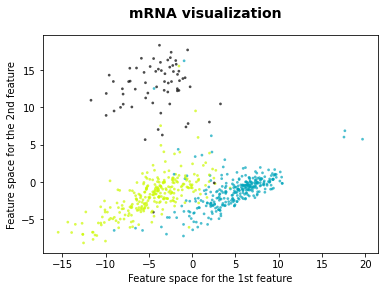



miRNA


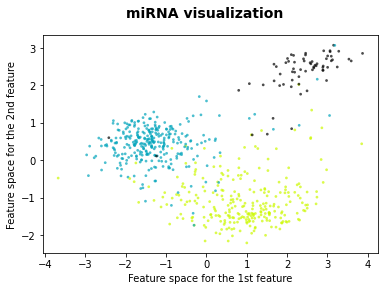



meth


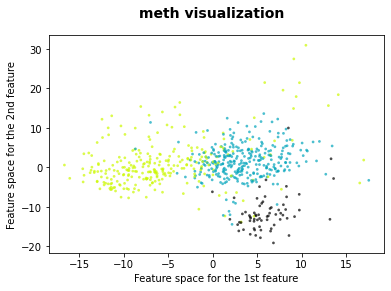

In [ ]:
for omic in ['mRNA','miRNA','meth']:
    print(omic)

    # Perform a 2D PCA to visualize the dataset
    pca = PCA(2)
    principalComponents = pca.fit_transform(ds[f'{omic}_normalized'])

    # Plot the clustered dataset with true cluster labels
    plot_2D_dataset(principalComponents, true_cluster_labels, title=f'{omic} visualization')

    print()
    print()